In [107]:
import pandas as pd

In [111]:
source = pd.read_csv("../data/source.csv")

In [112]:
ws = pd.read_csv("../data/weather/weather_stations.csv")
ws.head()

,StationNbr,Name,City,RegionalOffice,County,ConnectDate,DisconnectDate,IsActive,IsEtoStation,Elevation,GroundCover,HmsLatitude,HmsLongitude,ZipCodes,SitingDesc
0,1,Fresno/F.S.U. USDA,Fresno,South Central Region Office,Fresno,6/7/1982,9/25/1988,False,True,340,Grass,36º48'52N / 36.814444,-119º43'54W / -119.731670,"['93766', '93762', '93761', '93760', '93759', ...",NaN
1,2,FivePoints,Five Points,South Central Region Office,Fresno,6/7/1982,12/31/2050,True,True,285,Grass,36º20'10N / 36.336222,-120º6'46W / -120.112910,['93624'],NaN
2,3,Beach /Santa Cruz CO,Watsonville,South Central Region Office,Santa Cruz,5/30/1982,8/25/1986,False,True,10,Grass,36º52'50N / 36.880556,-121º47'36W / -121.793330,"['95077', '95076', '95075', '95019', '95018']",NaN
3,4,Webb /Santa Cruz CO,Watsonville,South Central Region Office,Santa Cruz,5/30/1982,4/29/1988,False,True,230,Grass,36º58'21N / 36.9725,-121º43'34W / -121.726110,"['95077', '95076', '95075', '95019', '95018']",NaN
4,5,Shafter,Shafter,South Central Region Office,Kern,6/1/1982,12/31/2050,True,True,360,Grass,35º31'57N / 35.532556,-119º16'54W / -119.281790,"['93263', '93280', '93388']",NaN


In [113]:
sce_ws = source["Weather Station"].str.lower().unique()
api_ws = ws.Name.str.lower()
matches = {}
for n in api_ws:
    for w in sce_ws:
        if n in w and n not in matches:
            matches[n]=w
matches

{'davis': 'sce mount davis',
 'soledad': 'sce soledad canyon rd',
 'santa paula': 'sce santa paula',
 'escondido': 'sce escondido canyon',
 'ramona': 'sce ramona expy',
 'moorpark': 'sce moorpark',
 'moreno valley': 'sce moreno valley fwy',
 'williams': 'sce williams canyon rd',
 'highland': 'highland springs raw',
 'chino': 'sce chino hills 3'}

In [114]:
ws_matches = ws[ws.Name.str.lower().isin(matches.keys())]
source_matches = ws_matches.Name.apply(lambda s: matches[s.lower()]).values

In [115]:
source[source["Weather Station"].str.lower().isin(source_matches)]["start", "end"]

KeyError: ('start', 'end')

In [119]:
wr = pd.read_csv("../data/weather/weather_report.csv")

(<AxesSubplot:>, 157)

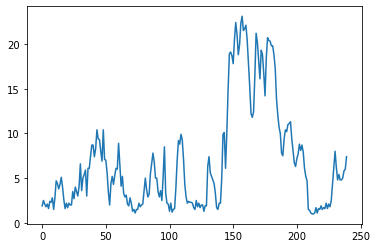

In [121]:
wr["HlyWindSpd (MPH)"].plot(), wr["HlyWindSpd (MPH)"].argmax()

<AxesSubplot:>

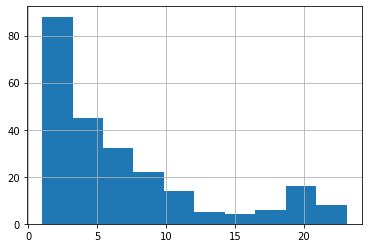

In [122]:
wr["HlyWindSpd (MPH)"].hist()

(<AxesSubplot:>, 157)

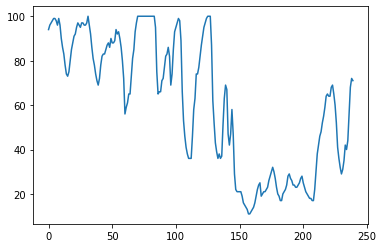

In [40]:
wr["HlyRelHum (%)"].plot(), wr["HlyRelHum (%)"].argmin()

In [46]:
date_cols = ["month", "days", "year"]
source[date_cols]

,month,days,year
0,Sept,5-11,2020
1,Sept,5-11,2020
2,Nov,29,2020
3,Nov,29,2020
4,Nov,29,2020
...,...,...,...
519,Jan,12-21,2021
520,Jan,12-21,2021
521,Jan,12-21,2021
522,Jan,12-21,2021


In [47]:
source[["event start", "event end"]] = source["days"].str.split("-", expand=True)
date_cols += ["event start", "event end"]

In [48]:
source[date_cols]

,month,days,year,event start,event end
0,Sept,5-11,2020,5,11
1,Sept,5-11,2020,5,11
2,Nov,29,2020,29,None
3,Nov,29,2020,29,None
4,Nov,29,2020,29,None
...,...,...,...,...,...
519,Jan,12-21,2021,12,21
520,Jan,12-21,2021,12,21
521,Jan,12-21,2021,12,21
522,Jan,12-21,2021,12,21


In [52]:
single_day_events = source["event end"].isna()
source.loc[source["event end"].isna(), "event end"] = source[single_day_events]["event start"]

In [73]:
source[date_cols]

,month,days,year,event start,event end,start,end
0,Sept,5-11,2020,5,11,2020-Sept-5,2020-Sept-11
1,Sept,5-11,2020,5,11,2020-Sept-5,2020-Sept-11
2,Nov,29,2020,29,29,2020-Nov-29,2020-Nov-29
3,Nov,29,2020,29,29,2020-Nov-29,2020-Nov-29
4,Nov,29,2020,29,29,2020-Nov-29,2020-Nov-29
...,...,...,...,...,...,...,...
519,Jan,12-21,2021,12,21,2021-Jan-12,2021-Jan-21
520,Jan,12-21,2021,12,21,2021-Jan-12,2021-Jan-21
521,Jan,12-21,2021,12,21,2021-Jan-12,2021-Jan-21
522,Jan,12-21,2021,12,21,2021-Jan-12,2021-Jan-21


In [76]:
str_combine = lambda s1, s2: str(s1) + "-" + str(s2)

In [77]:
source["start"] = source.year.combine(source.month, str_combine).combine(source["event start"], str_combine)
source["end"] = source.year.combine(source.month, str_combine).combine(source["event end"], str_combine)
date_cols += ["start", "end"]

In [78]:
for s in ["start", "end"]:
    source[s] = pd.to_datetime(source[s])

In [80]:
source["start"]

0     2020-09-05
1     2020-09-05
2     2020-11-29
3     2020-11-29
4     2020-11-29
         ...    
519   2021-01-12
520   2021-01-12
521   2021-01-12
522   2021-01-12
523   2021-01-12
Name: start, Length: 524, dtype: datetime64[ns]